In [1]:
import os
import pandas as pd
import os
from PIL import Image
from tqdm.auto import tqdm
from sklearn.model_selection import train_test_split

import numpy as np
import torchvision.transforms as transforms
from torch.autograd import Variable
import torch
import torch.nn as nn
import torch.nn.functional as F
# !pip install datasets
from datasets import load_dataset



In [2]:
from google.colab import drive
drive.mount('/content/drive')
import os


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# os.environ['KAGGLE_USERNAME'] = "" # username from the json file
# os.environ['KAGGLE_KEY'] = ""
# !kaggle datasets download -d niten19/face-shape-dataset


In [3]:
! unzip "/content/drive/MyDrive/FaceShape Dataset.zip"

Streaming output truncated to the last 5000 lines.
  inflating: FaceShape Dataset/testing_set/Oval/oval (508).jpg  
  inflating: FaceShape Dataset/testing_set/Oval/oval (509).jpg  
  inflating: FaceShape Dataset/testing_set/Oval/oval (51).jpg  
  inflating: FaceShape Dataset/testing_set/Oval/oval (510).jpg  
  inflating: FaceShape Dataset/testing_set/Oval/oval (511).jpg  
  inflating: FaceShape Dataset/testing_set/Oval/oval (512).jpg  
  inflating: FaceShape Dataset/testing_set/Oval/oval (513).jpg  
  inflating: FaceShape Dataset/testing_set/Oval/oval (514).jpg  
  inflating: FaceShape Dataset/testing_set/Oval/oval (516).jpg  
  inflating: FaceShape Dataset/testing_set/Oval/oval (517).jpg  
  inflating: FaceShape Dataset/testing_set/Oval/oval (518).jpg  
  inflating: FaceShape Dataset/testing_set/Oval/oval (519).jpg  
  inflating: FaceShape Dataset/testing_set/Oval/oval (520).jpg  
  inflating: FaceShape Dataset/testing_set/Oval/oval (521).jpg  
  inflating: FaceShape Dataset/testing_s

In [4]:
train_ds = load_dataset("imagefolder", data_dir='/content/FaceShape Dataset/training_set', split="train")
test_ds = load_dataset("imagefolder", data_dir='/content/FaceShape Dataset/testing_set', split="train")
# label2idx and idx2label

id2label = {id:label for id, label in enumerate(train_ds.features['label'].names)}
label2id = {label:id for id,label in id2label.items()}
# split train, val
# splits = train_ds.train_test_split(test_size=0.005, shuffle=True, seed=42)
# train_ds, val_ds = splits["train"], splits["test"]
splits = test_ds.train_test_split(test_size=0.5, shuffle=True, seed=42)
test_ds, val_ds = splits["train"], splits["test"]
print("Features", train_ds.features)
print("Train", train_ds)
print("Validation", val_ds)
print("Test", test_ds)
print("Num labels", len(label2id))
print("Label2Idx", label2id)
print("Label2Idx", id2label)


Resolving data files:   0%|          | 0/4502 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/1001 [00:00<?, ?it/s]

Features {'image': Image(decode=True, id=None), 'label': ClassLabel(names=['Heart', 'Oblong', 'Oval', 'Round', 'Square'], id=None)}
Train Dataset({
    features: ['image', 'label'],
    num_rows: 4500
})
Validation Dataset({
    features: ['image', 'label'],
    num_rows: 500
})
Test Dataset({
    features: ['image', 'label'],
    num_rows: 500
})
Num labels 5
Label2Idx {'Heart': 0, 'Oblong': 1, 'Oval': 2, 'Round': 3, 'Square': 4}
Label2Idx {0: 'Heart', 1: 'Oblong', 2: 'Oval', 3: 'Round', 4: 'Square'}


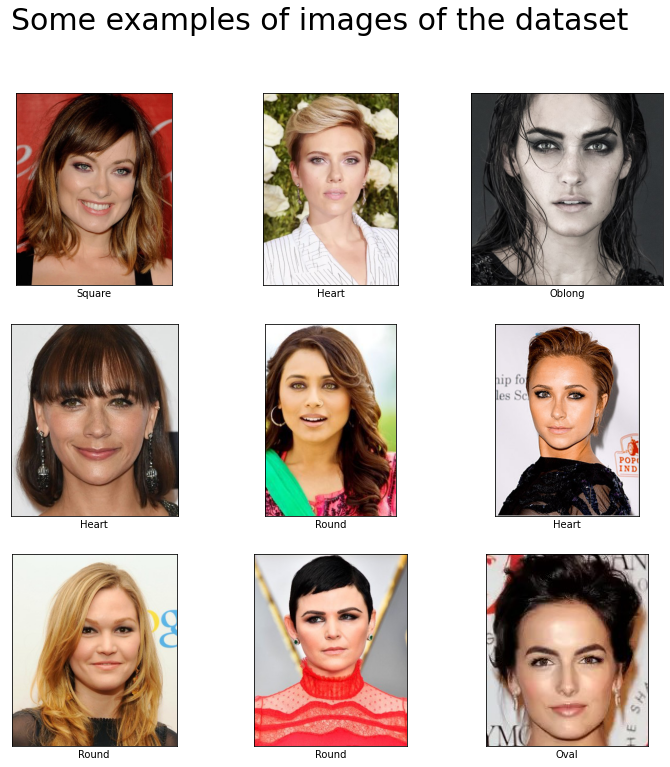

In [5]:
import cv2
import matplotlib.pyplot as plt  
from random import randint
list_idx = [randint(0, len(train_ds)) for i in range(9)]
def display_examples():
    fig = plt.figure(figsize=(12,12))
    fig.suptitle("Some examples of images of the dataset", fontsize=30)
    for i, idx in enumerate(list_idx):
        plt.subplot(3,3,i+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(train_ds[idx]["image"], cmap=plt.cm.binary)
        plt.xlabel(id2label[train_ds[idx]["label"]])
    plt.show()

display_examples()

In [6]:
#!pip install transformers
from transformers import AutoFeatureExtractor
import torchvision.transforms.functional

from torchvision.transforms import (
    CenterCrop, 
    Compose, 
    Normalize, 
    RandomHorizontalFlip,
    RandomResizedCrop, 
    Resize, 
    RandomAdjustSharpness,
    ToTensor
    
)

feature_extractor = AutoFeatureExtractor.from_pretrained("microsoft/swin-tiny-patch4-window7-224")

normalize = Normalize(mean=feature_extractor.image_mean, std=feature_extractor.image_std)
_train_transforms = Compose(
        [
            RandomResizedCrop(feature_extractor.size),
            RandomHorizontalFlip(),
            # RandomAdjustSharpness(2, 0.8),
            ToTensor(),
            normalize,
        ]
    )

_val_transforms = Compose(
        [
            Resize(feature_extractor.size),
            CenterCrop(feature_extractor.size),
            # RandomAdjustSharpness(2, p=0.8),

            ToTensor(),
            normalize,
        ]
    )

def train_transforms(examples):
    examples['pixel_values'] = [_train_transforms(image.convert("RGB")) for image in examples['image']]
    return examples

def val_transforms(examples):
    examples['pixel_values'] = [_val_transforms(image.convert("RGB")) for image in examples['image']]
    return examples

# Set the transforms
train_ds.set_transform(train_transforms)
val_ds.set_transform(val_transforms)
test_ds.set_transform(val_transforms)

In [7]:
feature_extractor.image_mean, feature_extractor.image_std

([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])

In [8]:
from torch.utils.data import DataLoader
import torch

def collate_fn(examples):
    pixel_values = torch.stack([example["pixel_values"] for example in examples])
    labels = torch.tensor([example["label"] for example in examples])
    return {"pixel_values": pixel_values, "labels": labels}

train_dataloader = DataLoader(train_ds, collate_fn=collate_fn, batch_size=64)

In [9]:
from transformers import SwinForImageClassification, SwinConfig

config = SwinConfig.from_pretrained(
        "microsoft/swin-tiny-patch4-window7-224",
        num_labels=len(label2id),
        label2id=label2id,
        id2label=id2label,
        finetuning_task="image-classification"
    )

model = SwinForImageClassification.from_pretrained(
    "microsoft/swin-tiny-patch4-window7-224",
    config=config,
    ignore_mismatched_sizes=True
)

/usr/local/lib/python3.7/dist-packages/torch/functional.py:478: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2894.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
Some weights of SwinForImageClassification were not initialized from the model checkpoint at microsoft/swin-tiny-patch4-window7-224 and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([5, 768]) in the model instantiated
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([5]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [10]:
model

SwinForImageClassification(
  (swin): SwinModel(
    (embeddings): SwinEmbeddings(
      (patch_embeddings): SwinPatchEmbeddings(
        (projection): Conv2d(3, 96, kernel_size=(4, 4), stride=(4, 4))
      )
      (norm): LayerNorm((96,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): SwinEncoder(
      (layers): ModuleList(
        (0): SwinStage(
          (blocks): ModuleList(
            (0): SwinLayer(
              (layernorm_before): LayerNorm((96,), eps=1e-05, elementwise_affine=True)
              (attention): SwinAttention(
                (self): SwinSelfAttention(
                  (query): Linear(in_features=96, out_features=96, bias=True)
                  (key): Linear(in_features=96, out_features=96, bias=True)
                  (value): Linear(in_features=96, out_features=96, bias=True)
                  (dropout): Dropout(p=0.0, inplace=False)
                )
                (output): SwinSelfOutput(
        

In [31]:
from transformers import TrainingArguments, Trainer
metric_name = "accuracy"
args = TrainingArguments(
    f"faceshape",
    save_strategy="epoch",
    evaluation_strategy="epoch",
    learning_rate=4e-5,
    per_device_train_batch_size=90,
    per_device_eval_batch_size=30,
    num_train_epochs=50,
    weight_decay=0.01,
    load_best_model_at_end=True,
    save_total_limit=1,
    metric_for_best_model=metric_name,
    logging_dir='logs',
    logging_steps=50,
    remove_unused_columns=False,
)

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


In [32]:
from datasets import load_metric
import numpy as np
#!pip install evaluate
import evaluate


metric = evaluate.load(metric_name)

def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return metric.compute(predictions=predictions, references=labels)

In [33]:
trainer = Trainer(
    model,
    args,
    train_dataset=train_ds,
    eval_dataset=val_ds,
    data_collator=collate_fn,
    compute_metrics=compute_metrics,
    tokenizer=feature_extractor,
)

In [34]:
torch.cuda.empty_cache()
import gc
gc.collect()


0

In [35]:
os.environ["WANDB_DISABLED"] = "true"
os.environ["WANDB_MODE"] = "offline"
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True
trainer.train()

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
***** Running training *****
  Num examples = 4500
  Num Epochs = 50
  Instantaneous batch size per device = 90
  Total train batch size (w. parallel, distributed & accumulation) = 90
  Gradient Accumulation steps = 1
  Total optimization steps = 2500
  Number of trainable parameters = 27523199


Epoch,Training Loss,Validation Loss,Accuracy
1,1.268900,1.190608,0.510000
2,1.136400,1.009162,0.598000
3,1.074400,0.867492,0.644000
4,0.999700,0.895377,0.652000
5,0.920200,0.816707,0.690000
6,0.850800,0.763153,0.728000
7,0.771000,0.729331,0.752000
8,0.731300,0.746274,0.740000
9,0.691800,0.643766,0.742000
10,0.662700,0.616984,0.760000


***** Running Evaluation *****
  Num examples = 500
  Batch size = 30
Saving model checkpoint to faceshape/checkpoint-50
Configuration saved in faceshape/checkpoint-50/config.json
Model weights saved in faceshape/checkpoint-50/pytorch_model.bin
Feature extractor saved in faceshape/checkpoint-50/preprocessor_config.json
Deleting older checkpoint [faceshape/checkpoint-100] due to args.save_total_limit
***** Running Evaluation *****
  Num examples = 500
  Batch size = 30
Saving model checkpoint to faceshape/checkpoint-100
Configuration saved in faceshape/checkpoint-100/config.json
Model weights saved in faceshape/checkpoint-100/pytorch_model.bin
Feature extractor saved in faceshape/checkpoint-100/preprocessor_config.json
Deleting older checkpoint [faceshape/checkpoint-50] due to args.save_total_limit
***** Running Evaluation *****
  Num examples = 500
  Batch size = 30
Saving model checkpoint to faceshape/checkpoint-150
Configuration saved in faceshape/checkpoint-150/config.json
Model wei

TrainOutput(global_step=2500, training_loss=0.43651262245178224, metrics={'train_runtime': 6718.9659, 'train_samples_per_second': 33.487, 'train_steps_per_second': 0.372, 'total_flos': 5.5930663337472e+18, 'train_loss': 0.43651262245178224, 'epoch': 50.0})

In [36]:
# !pip install pytest-shutil
import shutil

PATH = "entire_model3.pt"

# Save
torch.save(model, PATH)


shutil.copy(PATH,"/content/drive/MyDrive/FaceShapeDetection_saved_model")

'/content/drive/MyDrive/FaceShapeDetection_saved_model'

In [37]:
model_loaded= torch.load("/content/drive/MyDrive/FaceShapeDetection_saved_model")
trainer_loaded = Trainer(
    model_loaded,
    args,
    train_dataset=train_ds,
    eval_dataset=val_ds,
    data_collator=collate_fn,
    compute_metrics=compute_metrics,
    tokenizer=feature_extractor,
)


In [38]:
trainer_loaded.evaluate()

***** Running Evaluation *****
  Num examples = 500
  Batch size = 30


{'eval_loss': 0.4657686650753021,
 'eval_accuracy': 0.85,
 'eval_runtime': 10.5868,
 'eval_samples_per_second': 47.229,
 'eval_steps_per_second': 1.606}

In [39]:

outputs = trainer_loaded.predict(test_ds)
print(outputs.metrics)
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

y_true = outputs.label_ids
y_pred = outputs.predictions.argmax(1)
labels = train_ds.features['label'].names

***** Running Prediction *****
  Num examples = 500
  Batch size = 30


{'test_loss': 0.5840805768966675, 'test_accuracy': 0.818, 'test_runtime': 11.5008, 'test_samples_per_second': 43.475, 'test_steps_per_second': 1.478}


In [40]:

# Classification report
from sklearn.metrics import classification_report
print(classification_report(y_true, y_pred, target_names=labels))

              precision    recall  f1-score   support

       Heart       0.77      0.71      0.74        91
      Oblong       0.83      0.87      0.85       104
        Oval       0.78      0.77      0.78       111
       Round       0.85      0.79      0.82        97
      Square       0.85      0.94      0.89        97

    accuracy                           0.82       500
   macro avg       0.82      0.82      0.82       500
weighted avg       0.82      0.82      0.82       500



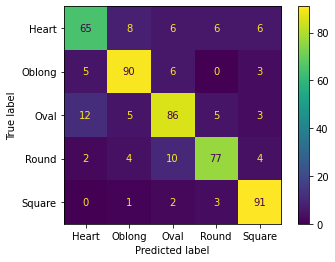

In [41]:

# Confusion matrix

cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot()

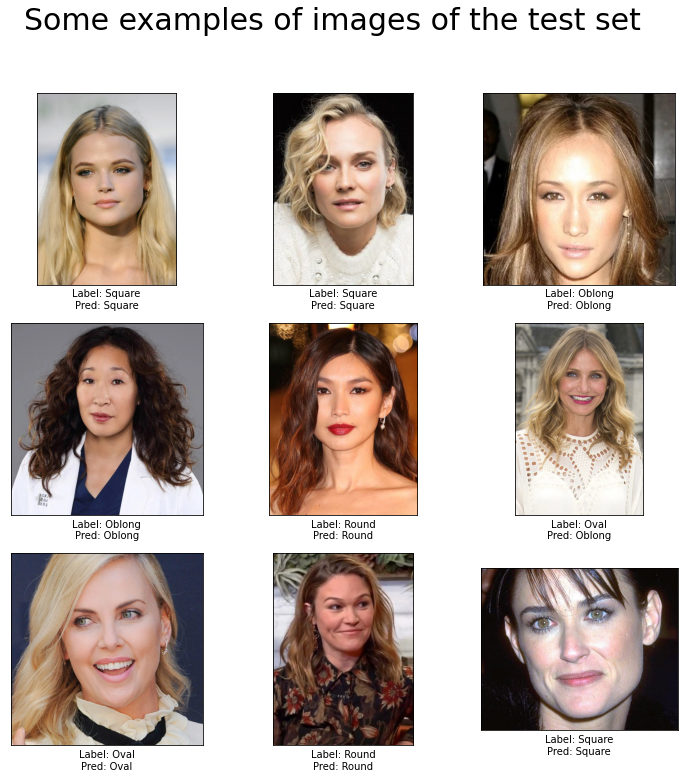

In [42]:
import cv2
import matplotlib.pyplot as plt
from random import randint

list_idx = [randint(0, len(test_ds)) for i in range(9)]

def display_examples():
    fig = plt.figure(figsize=(12,12))
    fig.suptitle("Some examples of images of the test set", fontsize=30)
    for i,idx in enumerate(list_idx):
        plt.subplot(3,3,i+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(test_ds[idx]["image"], cmap=plt.cm.binary)
        plt.xlabel("Label: "+id2label[y_true[idx]]+"\nPred: "+id2label[y_pred[idx]])
    plt.show()

display_examples()